In [1]:
!pip install tensorflow==2.12

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-11-05 06:03:01--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.37.32, 52.217.124.168, 52.216.212.248, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.37.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  6.82MB/s    in 1.9s    

2024-11-05 06:03:04 (6.82 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Analysis of the data of the Jena weather dataset - 420451 rows and 15 Features

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

line1 = data.split("\n")
header1 = line1[0].split(",")
line1 = line1[1:]
print(header1)
print(len(line1))

num_variables = len(header1)
print("Number of variables:", num_variables)
num_rows = len(line1)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


Following data analysis, specific values are kept in the temperature and raw_data arrays for subsequent processing or analysis. Comma-separated values are transformed to floating-point numbers.

In [4]:
import numpy as np
temp1 = np.zeros((len(line1),))
rawdata1 = np.zeros((len(line1), len(header1) - 1))
for i, line in enumerate(line1):
    values = [float(x) for x in line.split(",")[1:]]
    temp1[i] = values[1]
    rawdata1[i, :] = values[:]

The temperature timeseries plot

Text(0, 0.5, 'Temperature')

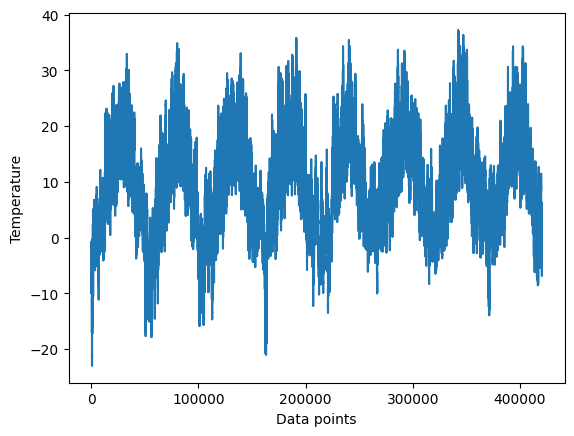

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temp1)), temp1)
plt.xlabel('Data points')
plt.ylabel('Temperature')

The temperature time series for the initial 10 days is plotted. 144 data points are gathered in a single day, therefore 1440 data points will be acquired in ten days.

Text(0, 0.5, 'Temperature')

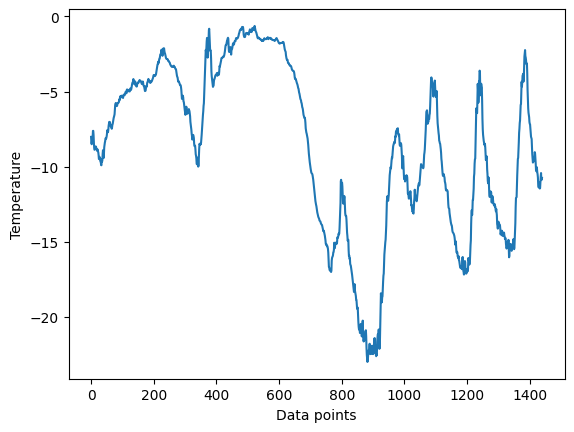

In [6]:
plt.plot(range(1440), temp1[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

Figuring out how many samples we'll need for each data split (train = 50%, validation = 25%).

In [7]:
num_of_train = int(0.5 * len(rawdata1))
num_of_validation= int(0.25 * len(rawdata1))
num_of_test= len(rawdata1) - num_of_train - num_of_validation
print("Number of train samples:", num_of_train)
print("Number of validation samples:", num_of_validation)
print("Number of test samples:", num_of_test)

Number of train samples: 210225
Number of validation samples: 105112
Number of test samples: 105114


Preparing the data

Normalizing the data: Since the data is already represented numerically, vectorization is not necessary. Nevertheless, because the data scales differ among them—temperature goes from -20 to +30, and pressure is measured in millibars—it is advisable to standardize all variables.

In [8]:
mean1 = rawdata1[:num_of_train].mean(axis=0)
rawdata1 -= mean1
std = rawdata1[:num_of_train].std(axis=0)
rawdata1 /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence1 = np.arange(10)
dummy_dataset1 = keras.utils.timeseries_dataset_from_array(
    data=int_sequence1[:-3],
    targets=int_sequence1[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset1:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


A significant amount of duplication in the dataset's sample makes the creation of training, validation, and testing datasets essential. To actively allocate RAM for each sample would therefore be inefficient. Instead, the samples will be generated in real time.

In [10]:
sample_rate = 6
sequencelength = 120
delay = sample_rate * (sequencelength + 24 - 1)
batch_size = 256

training_data = keras.utils.timeseries_dataset_from_array(
    rawdata1[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_of_train)

validation_data = keras.utils.timeseries_dataset_from_array(
    rawdata1[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_of_train,
    end_index=num_of_train + num_of_validation)

testing_data = keras.utils.timeseries_dataset_from_array(
    rawdata1[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_of_train + num_of_validation)

Generating the output of one of this datasets

In [11]:
for samples, targets in training_data:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


A common-sense, non-machine-learning baseline

Calculating the common-sense baseline MAE: The specified function "evaluate_naive_method" provides a foundation for evaluating the efficacy of a simple forecasting method that predicts the value that follows a given value using the final value in the input sequence.

In [12]:
def evaluate_naive_method(dataset):
    total_absolute_error = 0.
    samples_saw = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean1[1]
        total_absolute_error += np.sum(np.abs(preds - targets))
        samples_saw += samples.shape[0]
    return total_absolute_error / samples_saw

print(f"Validation MAE: {evaluate_naive_method(validation_data):.2f}")
print(f"Test MAE: {evaluate_naive_method(testing_data):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Predicting that the temperature will be the same 24 hours from now is a Common sense basilne approach. The validation mean absolute error (MAE) is 2.44 degrees Celsius whereas the test mean is 2.62 degrees Celsius utilizing this simple baseline. Stated otherwise, there would be an average variance of around 2.5 degrees if the future temperature were constant with the present one.

A basic machine-learning model - Dense Layer

Training and evaluating a densely connected model

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
G1 = layers.Flatten()(inputs)
G1 = layers.Dense(16, activation="relu")(G1)
outputs = layers.Dense(1)(G1)
model = keras.Model(inputs, outputs)

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])


history = model.fit(training_data, epochs=20,
                    validation_data = validation_data, callbacks=callbacks)

Epoch 1/20
819/819 [==============================] - 14s 16ms/step - loss: 12.0452 - mae: 2.6865 - val_loss: 10.8068 - val_mae: 2.5974
Epoch 2/20
819/819 [==============================] - 13s 16ms/step - loss: 8.7845 - mae: 2.3336 - val_loss: 11.8494 - val_mae: 2.7309
Epoch 3/20
819/819 [==============================] - 13s 16ms/step - loss: 8.0781 - mae: 2.2408 - val_loss: 10.5347 - val_mae: 2.5680
Epoch 4/20
819/819 [==============================] - 13s 16ms/step - loss: 7.6231 - mae: 2.1769 - val_loss: 11.9266 - val_mae: 2.7423
Epoch 5/20
819/819 [==============================] - 13s 16ms/step - loss: 7.3311 - mae: 2.1355 - val_loss: 11.6685 - val_mae: 2.7165
Epoch 6/20
819/819 [==============================] - 13s 16ms/step - loss: 7.0994 - mae: 2.1012 - val_loss: 11.1806 - val_mae: 2.6571
Epoch 7/20
819/819 [==============================] - 13s 16ms/step - loss: 6.8858 - mae: 2.0718 - val_loss: 11.3290 - val_mae: 2.6625
Epoch 8/20
819/819 [==============================] - 

In [15]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 4s 10ms/step - loss: 12.1246 - mae: 2.7338
Test MAE: 2.73


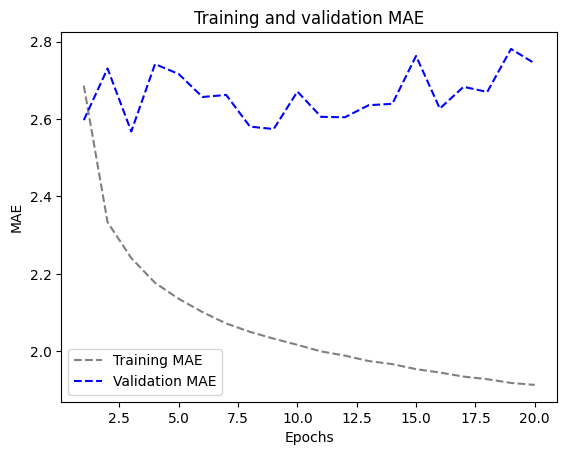

In [16]:
import matplotlib.pyplot as plt
loss1 = history.history["mae"]
validation_loss = history.history["val_mae"]

epochs = range(1, len(loss1) + 1)
plt.figure()
plt.plot(epochs, loss1, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Let's try a 1D convolutional model

In [17]:
inputs = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history1D = model.fit(training_data,
                    epochs=10,
                    validation_data=validation_data,
                    callbacks=callbacks)

model_to_dot = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(testing_data)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 21s 25ms/step - loss: 26.4000 - mae: 3.9483 - val_loss: 16.0040 - val_mae: 3.1175
Epoch 2/10
819/819 [==============================] - 20s 25ms/step - loss: 15.7543 - mae: 3.1449 - val_loss: 16.8795 - val_mae: 3.2665
Epoch 3/10
819/819 [==============================] - 21s 25ms/step - loss: 14.5645 - mae: 3.0242 - val_loss: 15.7441 - val_mae: 3.1092
Epoch 4/10
819/819 [==============================] - 21s 25ms/step - loss: 13.8380 - mae: 2.9448 - val_loss: 16.0852 - val_mae: 3.1515
Epoch 5/10
819/819 [==============================] - 20s 25ms/step - loss: 13.2808 - mae: 2.8839 - val_loss: 14.7700 - val_mae: 3.0306
Epoch 6/10
819/819 [==============================] - 21s 25ms/step - loss: 12.8890 - mae: 2.8387 - val_loss: 14.7629 - val_mae: 3.0309
Epoch 7/10
819/819 [==============================] - 21s 26ms/step - loss: 12.4847 - mae: 2.7884 - val_loss: 18.6077 - val_mae: 3.4733
Epoch 8/10
819/819 [============================

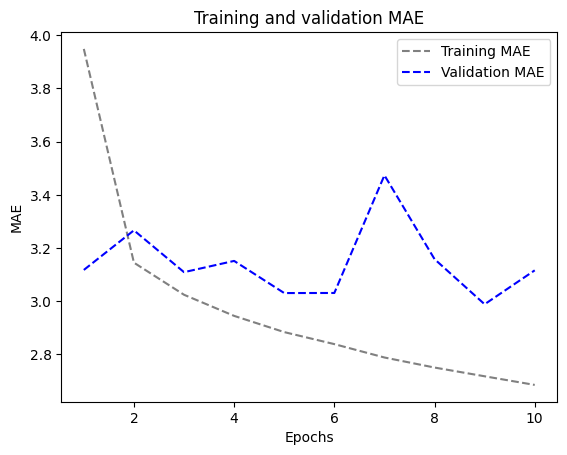

In [19]:
import matplotlib.pyplot as plt
loss1D = history1D.history["mae"]
validation_loss1D = history1D.history["val_mae"]

epochs = range(1, len(loss1D) + 1)
plt.figure()
plt.plot(epochs, loss1D, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss1D, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Dense models or common sense seem to outperform convolutional data. That might be because of

Weather data does not conform to the translation invariance assumption. The order in which the information is provided is crucial. Recent past data is notably more beneficial than data acquired many days in advance when it comes to predicting the temperature for the next day. Sadly, a 1D convolutional neural network is not able to adequately represent this significant temporal order.

A Simple RNN

1.An RNN layer that can process sequences of any length

In [20]:
the_features = 14
input_RNN = keras.Input(shape=(None, the_features))
output_RNN = layers.SimpleRNN(16)(input_RNN)

models_RNN = keras.Model(input_RNN, output_RNN)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
models_RNN.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_RNN = models_RNN.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models_RNN = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {models_RNN.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 22s 26ms/step - loss: 138.6124 - mae: 9.6757 - val_loss: 143.9894 - val_mae: 9.8919
Epoch 2/5
819/819 [==============================] - 21s 25ms/step - loss: 136.4758 - mae: 9.5652 - val_loss: 143.8651 - val_mae: 9.8868
Epoch 3/5
819/819 [==============================] - 20s 25ms/step - loss: 136.3643 - mae: 9.5570 - val_loss: 143.6878 - val_mae: 9.8661
Epoch 4/5
819/819 [==============================] - 21s 25ms/step - loss: 136.2702 - mae: 9.5464 - val_loss: 143.7424 - val_mae: 9.8729
Epoch 5/5
405/405 [==============================] - 5s 12ms/step - loss: 151.3971 - mae: 9.9304
Test MAE: 9.93


2.Simple RNN - Stacking RNN layers

In [21]:
the_features2 = 14
steps = 120
inpu2 = keras.Input(shape=(steps, the_features2))
a = layers.SimpleRNN(16, return_sequences=True)(inpu2)
a = layers.SimpleRNN(16, return_sequences=True)(a)
outpu2 = layers.SimpleRNN(16)(a)
models2 = keras.Model(inpu2, outpu2)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
models2.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history2 = models2.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models2 = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {models2.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 59s 70ms/step - loss: 136.8174 - mae: 9.5662 - val_loss: 143.4155 - val_mae: 9.8356
Epoch 2/5
819/819 [==============================] - 57s 69ms/step - loss: 135.9528 - mae: 9.5124 - val_loss: 143.4041 - val_mae: 9.8340
Epoch 3/5
819/819 [==============================] - 57s 69ms/step - loss: 135.9112 - mae: 9.5070 - val_loss: 143.4544 - val_mae: 9.8432
Epoch 4/5
819/819 [==============================] - 57s 69ms/step - loss: 135.8887 - mae: 9.5045 - val_loss: 143.3970 - val_mae: 9.8317
Epoch 5/5
405/405 [==============================] - 9s 21ms/step - loss: 151.1318 - mae: 9.9070
Test MAE: 9.91


A Simple GRU (Gated Recurrent Unit)

In [22]:
inputs_GRU = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
b = layers.GRU(16)(inputs_GRU)
outputs_GRU = layers.Dense(1)(b)
models_GRU = keras.Model(inputs_GRU, outputs_GRU)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
models_GRU.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_GRU = models_GRU.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models_GRU = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {models_GRU.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 46s 54ms/step - loss: 42.5877 - mae: 4.7406 - val_loss: 12.9575 - val_mae: 2.7068
Epoch 2/5
819/819 [==============================] - 44s 54ms/step - loss: 10.5300 - mae: 2.5264 - val_loss: 9.9407 - val_mae: 2.4117
Epoch 3/5
819/819 [==============================] - 44s 54ms/step - loss: 9.4840 - mae: 2.4039 - val_loss: 9.7019 - val_mae: 2.3808
Epoch 4/5
819/819 [==============================] - 45s 54ms/step - loss: 9.1298 - mae: 2.3570 - val_loss: 10.6240 - val_mae: 2.4552
Epoch 5/5
405/405 [==============================] - 7s 17ms/step - loss: 10.0502 - mae: 2.4868
Test MAE: 2.49


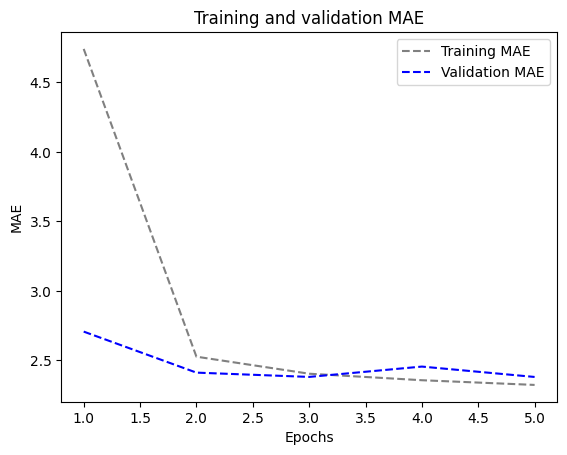

In [23]:
import matplotlib.pyplot as plt
loss_GRU = history_GRU.history["mae"]
validation_loss_GRU = history_GRU.history["val_mae"]

epochs = range(1, len(loss_GRU) + 1)
plt.figure()
plt.plot(epochs, loss_GRU, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_GRU, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM(Long Short-Term Memory )

1.LSTM-Simple

In [24]:
inputs_LSTMS = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
c = layers.LSTM(16)(inputs_LSTMS)
output_LSTMS = layers.Dense(1)(c)
model_LSTMS = keras.Model(inputs_LSTMS, output_LSTMS)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model_LSTMS.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_LSTMS = model_LSTMS.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 51s 60ms/step - loss: 36.2371 - mae: 4.3624 - val_loss: 11.4865 - val_mae: 2.5950
Epoch 2/5
819/819 [==============================] - 47s 57ms/step - loss: 10.3823 - mae: 2.5019 - val_loss: 9.7631 - val_mae: 2.4301
Epoch 3/5
819/819 [==============================] - 48s 58ms/step - loss: 9.2574 - mae: 2.3679 - val_loss: 9.5843 - val_mae: 2.4098
Epoch 4/5
819/819 [==============================] - 48s 58ms/step - loss: 8.7810 - mae: 2.3069 - val_loss: 9.7165 - val_mae: 2.4152
Epoch 5/5
819/819 [==============================] - 47s 57ms/step - loss: 8.4589 - mae: 2.2674 - val_loss: 9.9850 - val_mae: 2.4754


In [25]:
model_LSTMS = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model_LSTMS.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 9s 22ms/step - loss: 11.3230 - mae: 2.6185
Test MAE: 2.62


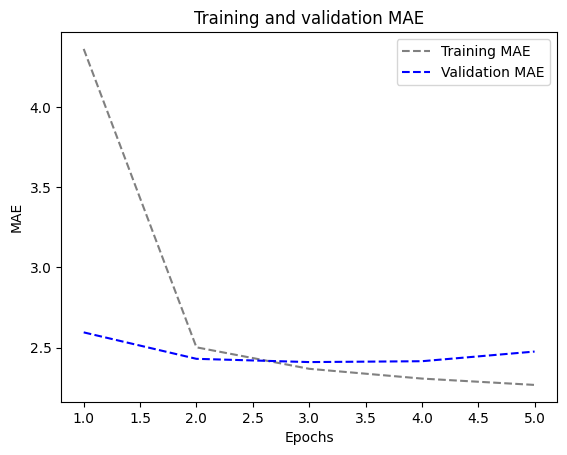

In [26]:
import matplotlib.pyplot as plt
loss_LSTMS = history_LSTMS.history["mae"]
validation_loss_LSTMS = history_LSTMS.history["val_mae"]

epochs = range(1, len(loss_LSTMS) + 1)
plt.figure()
plt.plot(epochs, loss_LSTMS, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_LSTMS, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

2.LSTM - dropout Regularization

In [27]:
input_LSTMR = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
d = layers.LSTM(16, recurrent_dropout=0.25)(input_LSTMR )
d = layers.Dropout(0.5)(d)
output_LSTMR = layers.Dense(1)(d)
model_LSTMR = keras.Model(input_LSTMR , output_LSTMR )

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model_LSTMR.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_LSTMR = model_LSTMR.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 63s 74ms/step - loss: 45.0087 - mae: 5.0057 - val_loss: 12.9218 - val_mae: 2.7177
Epoch 2/5
819/819 [==============================] - 61s 75ms/step - loss: 19.9979 - mae: 3.4353 - val_loss: 9.9902 - val_mae: 2.4546
Epoch 3/5
819/819 [==============================] - 61s 74ms/step - loss: 18.2268 - mae: 3.2857 - val_loss: 9.8223 - val_mae: 2.4475
Epoch 4/5
819/819 [==============================] - 60s 74ms/step - loss: 17.4911 - mae: 3.2170 - val_loss: 9.6533 - val_mae: 2.4230
Epoch 5/5
819/819 [==============================] - 61s 75ms/step - loss: 16.9608 - mae: 3.1652 - val_loss: 9.7137 - val_mae: 2.4336


In [28]:
model_LSTMR = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model_LSTMR.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 7s 18ms/step - loss: 11.3158 - mae: 2.6440
Test MAE: 2.64


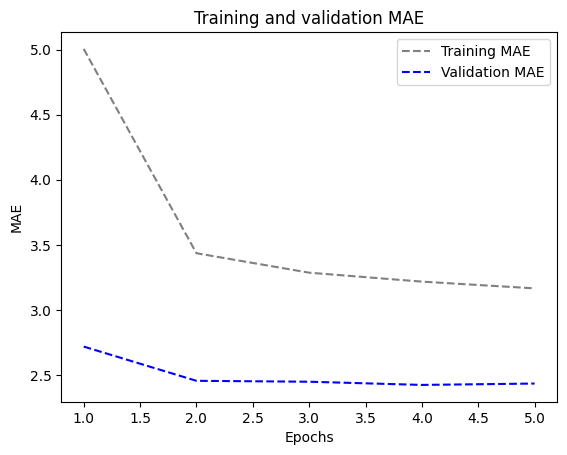

In [29]:
import matplotlib.pyplot as plt
loss_LSTMR = history_LSTMR .history["mae"]
validation_loss_LSTMR = history_LSTMR .history["val_mae"]

epochs = range(1, len(loss_LSTMR) + 1)
plt.figure()
plt.plot(epochs, loss_LSTMR, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_LSTMR, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

3.LSTM - Stacked setup with 16 units

In [30]:
input_16 = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
e = layers.LSTM(16, return_sequences=True)(input_16)
e = layers.LSTM(16)(e)
output_16 = layers.Dense(1)(e)
model_16 = keras.Model(input_16, output_16)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model_16.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_16 = model_16.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 95s 112ms/step - loss: 40.7777 - mae: 4.6530 - val_loss: 13.7474 - val_mae: 2.7951
Epoch 2/5
819/819 [==============================] - 91s 111ms/step - loss: 10.5412 - mae: 2.5283 - val_loss: 10.3929 - val_mae: 2.4870
Epoch 3/5
819/819 [==============================] - 91s 112ms/step - loss: 9.2325 - mae: 2.3684 - val_loss: 10.9594 - val_mae: 2.5420
Epoch 4/5
819/819 [==============================] - 93s 113ms/step - loss: 8.5649 - mae: 2.2795 - val_loss: 10.3091 - val_mae: 2.4750
Epoch 5/5
819/819 [==============================] - 98s 120ms/step - loss: 8.0894 - mae: 2.2136 - val_loss: 10.7779 - val_mae: 2.5083


In [31]:
model_16 = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model_16.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 18s 43ms/step - loss: 10.8945 - mae: 2.5739
Test MAE: 2.57


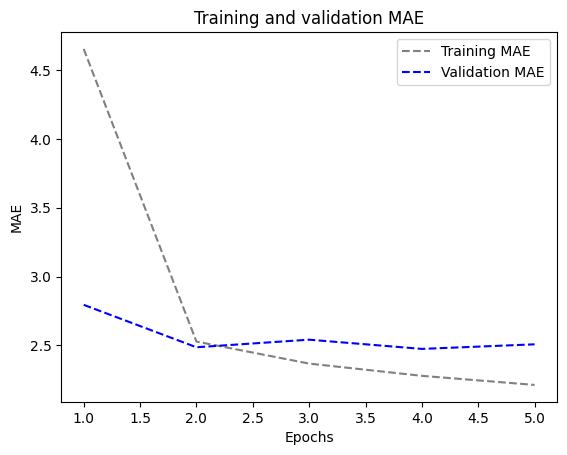

In [32]:
import matplotlib.pyplot as plt
loss_16 = history_16.history["mae"]
validation_loss_16 = history_16.history["val_mae"]

epochs = range(1, len(loss_16) + 1)
plt.figure()
plt.plot(epochs, loss_16, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_16, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

4.LSTM - Stacked setup with 32 units

In [33]:
input_32 = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
f = layers.LSTM(32, return_sequences=True)(input_32)
f = layers.LSTM(32)(f)
output_32 = layers.Dense(1)(f)
model_32 = keras.Model(input_32, output_32)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model_32.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_32 = model_32.fit(training_data,
                    epochs=10,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 135s 161ms/step - loss: 21.3956 - mae: 3.3080 - val_loss: 10.6142 - val_mae: 2.5291
Epoch 2/10
819/819 [==============================] - 133s 163ms/step - loss: 7.7380 - mae: 2.1641 - val_loss: 10.6745 - val_mae: 2.5648
Epoch 3/10
819/819 [==============================] - 131s 159ms/step - loss: 6.3248 - mae: 1.9475 - val_loss: 11.3574 - val_mae: 2.6522
Epoch 4/10
819/819 [==============================] - 132s 161ms/step - loss: 5.2764 - mae: 1.7738 - val_loss: 12.6916 - val_mae: 2.7843
Epoch 5/10
819/819 [==============================] - 131s 160ms/step - loss: 4.5091 - mae: 1.6370 - val_loss: 13.0164 - val_mae: 2.8446
Epoch 6/10
819/819 [==============================] - 131s 160ms/step - loss: 3.9636 - mae: 1.5276 - val_loss: 13.2187 - val_mae: 2.8367
Epoch 7/10
819/819 [==============================] - 131s 160ms/step - loss: 3.6076 - mae: 1.4539 - val_loss: 13.6979 - val_mae: 2.9090
Epoch 8/10
819/819 [====================

In [34]:
model_32 = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model_32.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 25s 60ms/step - loss: 11.8499 - mae: 2.6846
Test MAE: 2.68


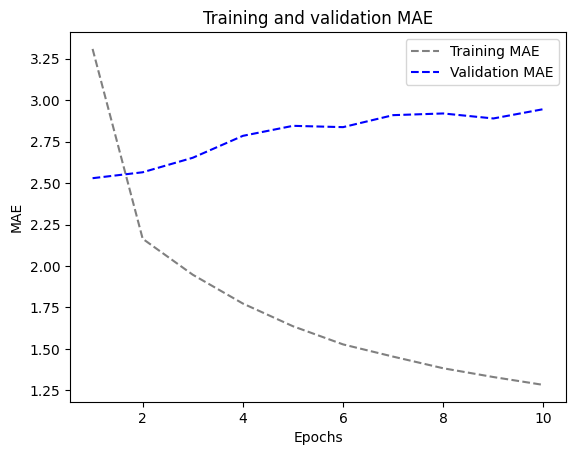

In [35]:
import matplotlib.pyplot as plt
loss_32 = history_32.history["mae"]
validation_loss_32 = history_32.history["val_mae"]

epochs = range(1, len(loss_32) + 1)
plt.figure()
plt.plot(epochs, loss_32, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_32, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

5.LSTM - Stacked setup with 8 units

In [36]:
input_8u = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
h = layers.LSTM(8, return_sequences=True)(input_8u)
h = layers.LSTM(8)(h)
output_8u = layers.Dense(1)(h)
model_8u = keras.Model(input_8u, output_8u)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model_8u.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_8u = model_8u.fit(training_data,
                    epochs=10,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 80s 94ms/step - loss: 83.6946 - mae: 7.0961 - val_loss: 44.6675 - val_mae: 5.0133
Epoch 2/10
819/819 [==============================] - 76s 93ms/step - loss: 25.9108 - mae: 3.7350 - val_loss: 14.6795 - val_mae: 2.8299
Epoch 3/10
819/819 [==============================] - 76s 93ms/step - loss: 11.8872 - mae: 2.6448 - val_loss: 10.2768 - val_mae: 2.4627
Epoch 4/10
819/819 [==============================] - 75s 92ms/step - loss: 9.8301 - mae: 2.4411 - val_loss: 9.6133 - val_mae: 2.4042
Epoch 5/10
819/819 [==============================] - 76s 93ms/step - loss: 9.3754 - mae: 2.3865 - val_loss: 9.8600 - val_mae: 2.4397
Epoch 6/10
819/819 [==============================] - 75s 92ms/step - loss: 9.0854 - mae: 2.3511 - val_loss: 9.4056 - val_mae: 2.3749
Epoch 7/10
819/819 [==============================] - 76s 93ms/step - loss: 8.8377 - mae: 2.3241 - val_loss: 9.5384 - val_mae: 2.3971
Epoch 8/10
819/819 [==============================] - 75

In [37]:
model_8u = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model_8u.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 13s 31ms/step - loss: 10.5655 - mae: 2.5485
Test MAE: 2.55


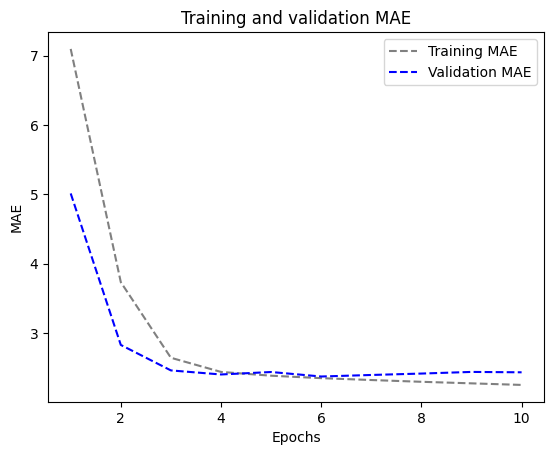

In [38]:
import matplotlib.pyplot as plt
loss_8u = history_8u.history["mae"]
validation_loss_8u = history_8u.history["val_mae"]

epochs = range(1, len(loss_8u) + 1)
plt.figure()
plt.plot(epochs, loss_8u, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_8u, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

6.LSTM - dropout-regularized, stacked model

In [39]:
inputs = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
i = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
i = layers.LSTM(8, recurrent_dropout=0.5)(i)
i = layers.Dropout(0.5)(i)
outputs = layers.Dense(1)(i)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_data,
                    epochs=10,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 111s 131ms/step - loss: 77.4515 - mae: 6.7849 - val_loss: 38.3474 - val_mae: 4.6167
Epoch 2/10
819/819 [==============================] - 106s 130ms/step - loss: 32.7173 - mae: 4.2595 - val_loss: 14.7777 - val_mae: 2.8700
Epoch 3/10
819/819 [==============================] - 107s 131ms/step - loss: 24.5228 - mae: 3.7427 - val_loss: 11.5339 - val_mae: 2.6041
Epoch 4/10
819/819 [==============================] - 107s 130ms/step - loss: 22.3103 - mae: 3.5812 - val_loss: 10.2491 - val_mae: 2.4688
Epoch 5/10
819/819 [==============================] - 107s 130ms/step - loss: 21.0526 - mae: 3.4813 - val_loss: 9.8957 - val_mae: 2.4321
Epoch 6/10
819/819 [==============================] - 107s 130ms/step - loss: 20.0226 - mae: 3.3992 - val_loss: 10.0048 - val_mae: 2.4553
Epoch 7/10
819/819 [==============================] - 107s 130ms/step - loss: 19.2403 - mae: 3.3342 - val_loss: 9.4321 - val_mae: 2.3849
Epoch 8/10
819/819 [================

In [40]:
model_r = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model_r.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 12s 28ms/step - loss: 10.7076 - mae: 2.5495
Test MAE: 2.55


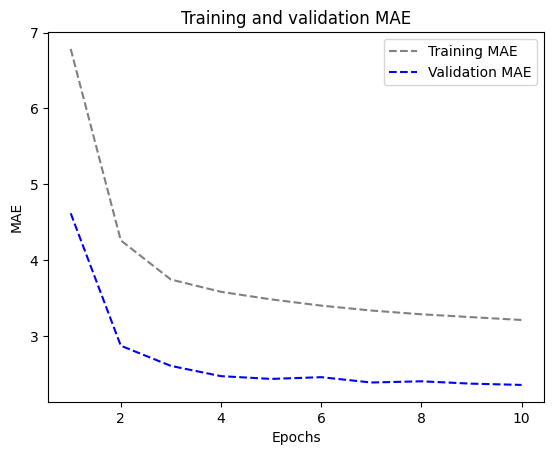

In [41]:
import matplotlib.pyplot as plt
loss_r = history.history["mae"]
validation_loss_r = history.history["val_mae"]

epochs = range(1, len(loss_r) + 1)
plt.figure()
plt.plot(epochs, loss_r, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_r, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Bidirectional LSTM

In [42]:
inputs = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history.bi = model.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                     callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 55s 63ms/step - loss: 24.2825 - mae: 3.5753 - val_loss: 11.6624 - val_mae: 2.6455
Epoch 2/5
819/819 [==============================] - 51s 63ms/step - loss: 9.4036 - mae: 2.3918 - val_loss: 10.2716 - val_mae: 2.4764
Epoch 3/5
819/819 [==============================] - 52s 63ms/step - loss: 8.4239 - mae: 2.2597 - val_loss: 10.3157 - val_mae: 2.4895
Epoch 4/5
819/819 [==============================] - 51s 62ms/step - loss: 7.8794 - mae: 2.1842 - val_loss: 10.5304 - val_mae: 2.5087
Epoch 5/5
819/819 [==============================] - 51s 63ms/step - loss: 7.4591 - mae: 2.1257 - val_loss: 10.8015 - val_mae: 2.5404


In [43]:
model_bi = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model_bi.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 11s 26ms/step - loss: 10.7618 - mae: 2.5669
Test MAE: 2.57


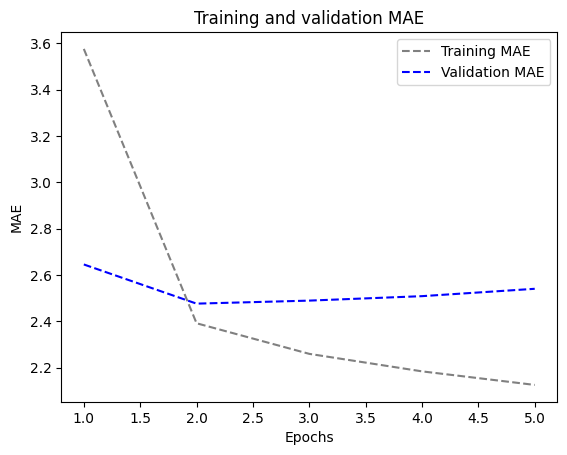

In [44]:
import matplotlib.pyplot as plt
loss_bi = history.bi.history["mae"]
validation_loss_bi = history.bi.history["val_mae"]

epochs = range(1, len(loss_bi) + 1)
plt.figure()
plt.plot(epochs, loss_bi, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_bi, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

1D Convnets and LSTM togther

In [45]:
input_final = keras.Input(shape=(sequencelength, rawdata1.shape[-1]))
l = layers.Conv1D(64, 3, activation='relu')(input_final)
l = layers.MaxPooling1D(3)(l)
l = layers.Conv1D(128, 3, activation='relu')(l)
l = layers.GlobalMaxPooling1D()(l)
l = layers.Reshape((-1, 128))(l)  # Reshape the data to be 3D
l = layers.LSTM(16)(l)
output_final = layers.Dense(1)(l)
model_final = keras.Model(input_final, output_final)

model_final.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history_final = model_final.fit(training_data, epochs=5, validation_data=validation_data, callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 32s 36ms/step - loss: 43.9835 - mae: 4.9519 - val_loss: 26.7604 - val_mae: 3.9949
Epoch 2/5
819/819 [==============================] - 29s 35ms/step - loss: 16.9126 - mae: 3.1812 - val_loss: 25.4092 - val_mae: 3.9474
Epoch 3/5
819/819 [==============================] - 29s 35ms/step - loss: 14.1405 - mae: 2.9196 - val_loss: 24.8320 - val_mae: 3.9632
Epoch 4/5
819/819 [==============================] - 29s 35ms/step - loss: 12.6689 - mae: 2.7555 - val_loss: 24.0716 - val_mae: 3.8751
Epoch 5/5
819/819 [==============================] - 29s 35ms/step - loss: 11.6056 - mae: 2.6340 - val_loss: 23.6682 - val_mae: 3.8880


In [46]:
model_final = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model_final.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 6s 14ms/step - loss: 23.4822 - mae: 3.8894
Test MAE: 3.89


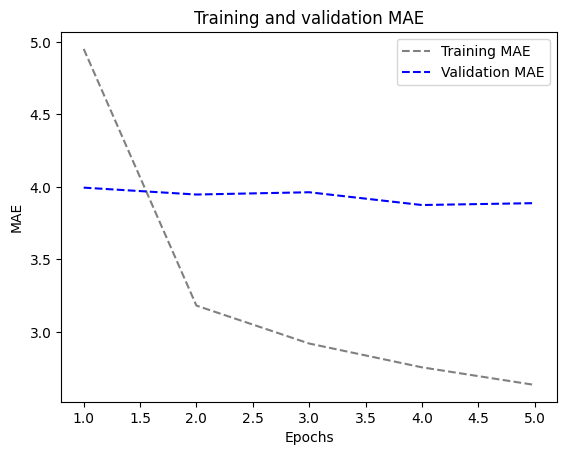

In [47]:
import matplotlib.pyplot as plt
loss_final = history_final.history["mae"]
validation_loss_final = history_final.history["val_mae"]

epochs = range(1, len(loss_final) + 1)
plt.figure()
plt.plot(epochs, loss_final, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_final, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Built 14 models: Following are the details;

Model 1: common-sense, non-machine-learning baseline

Model 2: A basic machine-learning model

Model 3: 1D convolutional model

Model 4: Simple RNN layer that can process sequences of any length

Model 5: Simple RNN - Stacking RNN layers

Model 6: A Simple GRU (Gated Recurrent Unit)

Model 7: LSTM-Simple

Model 8: LSTM - dropout Regularization

Model 9: Stacked setup with 16 units

Model 10: Stacked setup with 32 units

Model 11: Stacked setup with 8 units

Model 12: LSTM - dropout-regularized, stacked

Model 13: Bidirectional LSTM

Model 14: 1D Convnets and LSTM togther

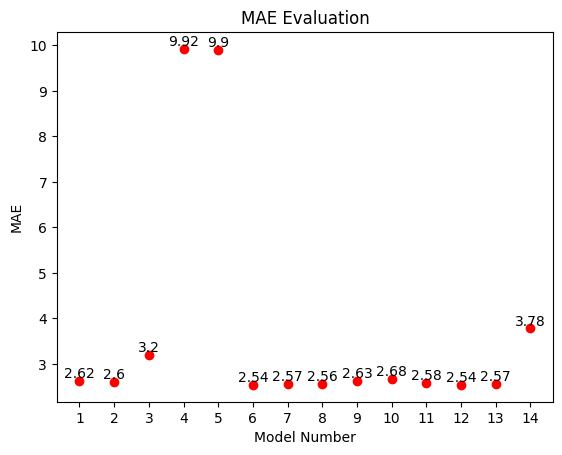

In [48]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.60,3.2,9.92,9.9,2.54,2.57,2.56,2.63,2.68,2.58,2.54,2.57,3.78)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

In [1]:
!jupyter nbconvert --to html /content/Assignment_Time_Series_Data.ipynb


[NbConvertApp] WARNING | pattern '/content/Assignment_Time_Series_Data.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answe